In [70]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random

from sklearn.manifold import TSNE
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report

#### Рассмотрим набор данных для бинарной классификации ребер в графе

In [72]:
from torch_geometric.datasets import Amazon

dataset = Amazon(root='/tmp/Amazon', name='Photo')
graph = dataset[0]
display(dataset)

AmazonPhoto()

#### Это датасет Амазона - и в нем один большой граф; т.к. мы решаем задачу классификации ребер, нам больше графов и не нужно; лучше иметь один большой

#### Сам датасет - про товары из категории "Фотоаппараты"; а связи - просмотр/покупка товаров из этой категории вместе

In [73]:
display(pd.DataFrame([[dataset, len(dataset), dataset.num_node_features, dataset.num_edge_features, dataset.num_classes]],
                     columns=["Датасет",
                              "Количество графов",
                              "Количество признаков вершин",
                              "Количество признаков ребер",
                              "Количество классов"]).T)

,0
Датасет,"([(x, tensor([[0., 0., 0., ..., 0., 1., 0.],\..."
Количество графов,1
Количество признаков вершин,745
Количество признаков ребер,0
Количество классов,8


#### Некоторую статистику по графу также визуализируем

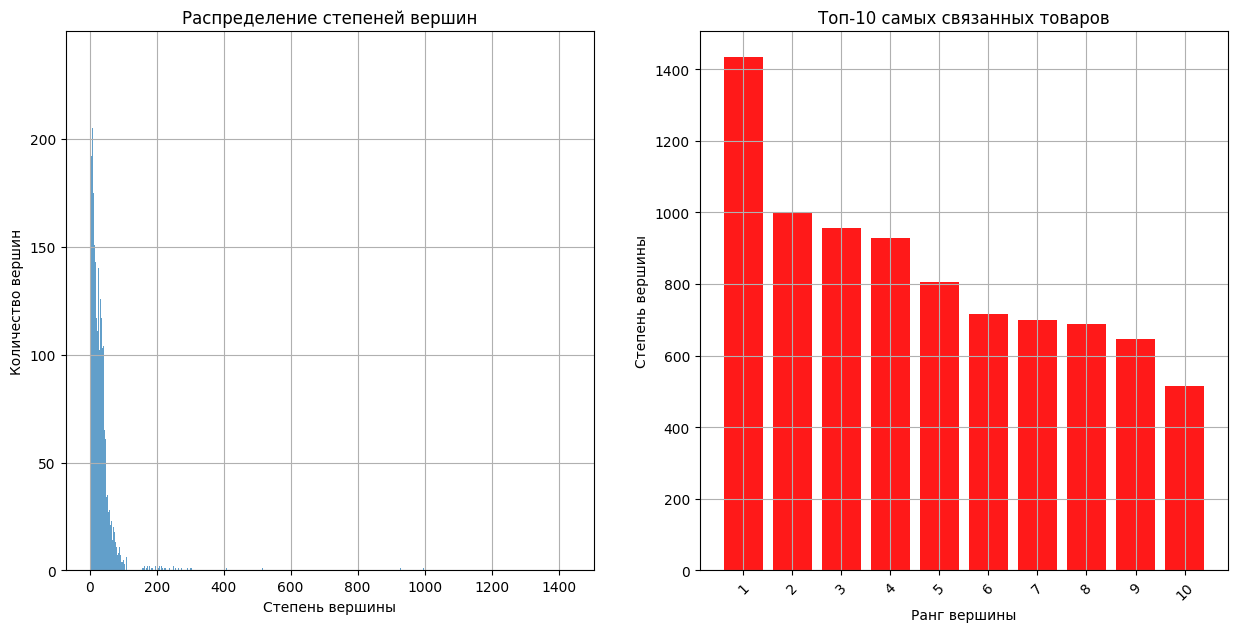

In [283]:
plt.figure(figsize=(15, 7))

degrees = torch.zeros(graph.num_nodes, dtype=torch.long)
degrees = torch.scatter_add(degrees, 0, graph.edge_index[0], torch.ones(graph.num_edges, dtype=torch.long))

# Распределение степеней вершин
plt.subplot(1, 2, 1)
degree_counts = torch.bincount(degrees)
plt.bar(range(len(degree_counts)), degree_counts.numpy(), alpha=0.7)
plt.xlabel('Степень вершины')
plt.ylabel('Количество вершин')
plt.title('Распределение степеней вершин')
plt.grid(True)

# Top-10 самых связанных товаров
plt.subplot(1, 2, 2)
top_count = 10
top_degrees, top_indices = torch.topk(degrees, top_count)
plt.bar(range(top_count), top_degrees.numpy(), color='red', alpha=0.9)
plt.xlabel('Ранг вершины')
plt.ylabel('Степень вершины')
plt.title(f'Топ-{top_count} самых связанных товаров')
plt.xticks(range(top_count), [f'{i+1}' for i in range(top_count)], rotation=45)
plt.grid(True)

#### Визуализируем граф

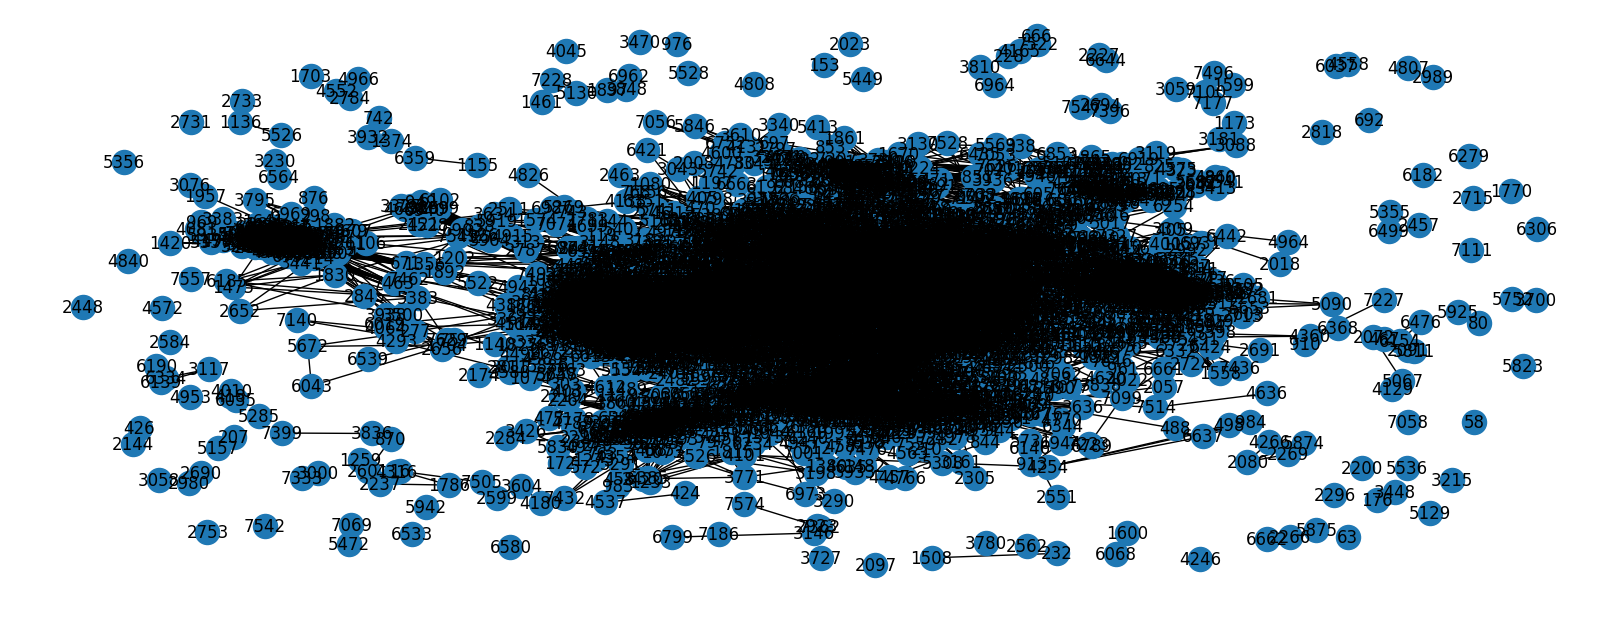

In [75]:
from torch_geometric.utils import to_networkx
G = to_networkx(graph, to_undirected=True)
plt.figure(figsize=(16, 6))
nx.draw(G, with_labels=True)
# Тут конечно мало что понятно....

#### Теперь реализуем алгоритм DeepWalk; только учтем одну вещь - граф у нас достаточно большой и сам по себе алгоритм DeepWalk отработает быстро, но дальнейшее обучение будет очень долгим; с другой стороны датасет у нас интересный и менять его не хочется - поэтому возьмем подграф нашего большого графа и будем оперировать им

#### Алгоритм DeepWalk

In [76]:
def deep_walk(G, num_walks = 10, walk_length = 5):
    walks = []
    for node in tqdm(G.nodes()):
        for i in range(num_walks):
            actual_node = node
            deep_walk_array = [actual_node]
            for j in range(walk_length):
                neighbors_array = list(G.neighbors(actual_node))
                if len(neighbors_array) > 0:
                    next_node = int(np.random.choice(neighbors_array))
                    deep_walk_array.append(next_node)
                    actual_node = next_node
                else:
                    break
            walks.append(deep_walk_array)
    return walks

In [79]:
# Сначала просто посмотрим, что он примерно возвращает

walks = deep_walk(G)
display(walks[:10]) # для примера

100%|██████████| 7650/7650 [00:02<00:00, 3707.92it/s]


[[0, 3578, 2287, 5844, 2484, 3152],
 [0, 5372, 1997, 77, 7003, 4071],
 [0, 4337, 5406, 4337, 5007, 1782],
 [0, 4337, 2166, 2042, 7330, 3643],
 [0, 5167, 3080, 4381, 2198, 1184],
 [0, 4771, 3866, 5208, 5070, 5372],
 [0, 2198, 432, 2977, 1695, 1058],
 [0, 4771, 1058, 2406, 1169, 2406],
 [0, 3152, 1711, 1113, 5381, 7582],
 [0, 5167, 5007, 2484, 5404, 2043]]

#### Теперь возьмем подграф для быстрого обучения эмбеддингов, используем идею negative sampling (т е с отсутствующими ребрами в графе) и в качестве оптимизатора возьмем SGD - а затем эмбеддинги визуализируем и посмотрим, что получится

In [119]:
# Создадим подграф
subgraph_size = 800
G_sub = nx.Graph()
edges = graph.edge_index.numpy().T
G_sub.add_edges_from([(u, v) for u, v in edges if u < subgraph_size and v < subgraph_size])
print(f"Подграф: {G_sub.number_of_nodes()} вершин")
print(f"Подграф: {G_sub.number_of_edges()} ребер")


# Теперь обучение эмбеддингов
def train(G_sub, epoch_cnt=50, negative_samples=5):
    walks = deep_walk(G_sub, num_walks=13, walk_length=5)

    emb_sample = nn.Embedding(subgraph_size, 32)
    nn.init.normal_(emb_sample.weight, mean=0.0, std=0.1)
    optimizer = torch.optim.SGD(emb_sample.parameters(), lr=0.01)

    for epoch in range(epoch_cnt):
        total_loss = 0
        batch_count = 0

        for walk in walks:
            for i, target in enumerate(walk):
                if i < len(walk) - 1:
                    context = walk[i + 1]
                    # positive samplings
                    product = (emb_sample(torch.tensor(target)) * emb_sample(torch.tensor(context))).sum()
                    pred = torch.sigmoid(product)
                    positive_loss = -torch.log(pred)

                    # negative samplings - target и случайные вершины должны быть далеки
                    negative_loss = 0
                    for _ in range(negative_samples):
                        negative_node = random.randint(0, subgraph_size - 1)
                        # Убедимся, что это действительно негативный пример
                        while negative_node == context or negative_node == target:
                            negative_node = random.randint(0, subgraph_size - 1)

                        negative_score = (
                                emb_sample(torch.tensor(target)) * emb_sample(torch.tensor(negative_node))).sum()
                        negative_loss += -torch.log(1 - torch.sigmoid(negative_score))

                    negative_loss /= negative_samples  # усредним

                    loss = positive_loss + negative_loss
                    total_loss += loss.item()
                    batch_count += 1

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
        if epoch % 5 == 0:
            avg_loss = total_loss / batch_count
            print(f"Эпоха {epoch}, Loss: {avg_loss:.4f}")
    return emb_sample

Подграф: 599 вершин
Подграф: 1261 ребер


In [196]:
deep_walk_embeddings = train(G_sub, negative_samples=5, epoch_cnt=60)

100%|██████████| 599/599 [00:00<00:00, 1836.25it/s]


Эпоха 0, Loss: 1.3215
Эпоха 5, Loss: 0.7853
Эпоха 10, Loss: 0.7659
Эпоха 15, Loss: 0.7544
Эпоха 20, Loss: 0.7456
Эпоха 25, Loss: 0.7412
Эпоха 30, Loss: 0.7331
Эпоха 35, Loss: 0.7238
Эпоха 40, Loss: 0.7177
Эпоха 45, Loss: 0.7120
Эпоха 50, Loss: 0.7052
Эпоха 55, Loss: 0.6984


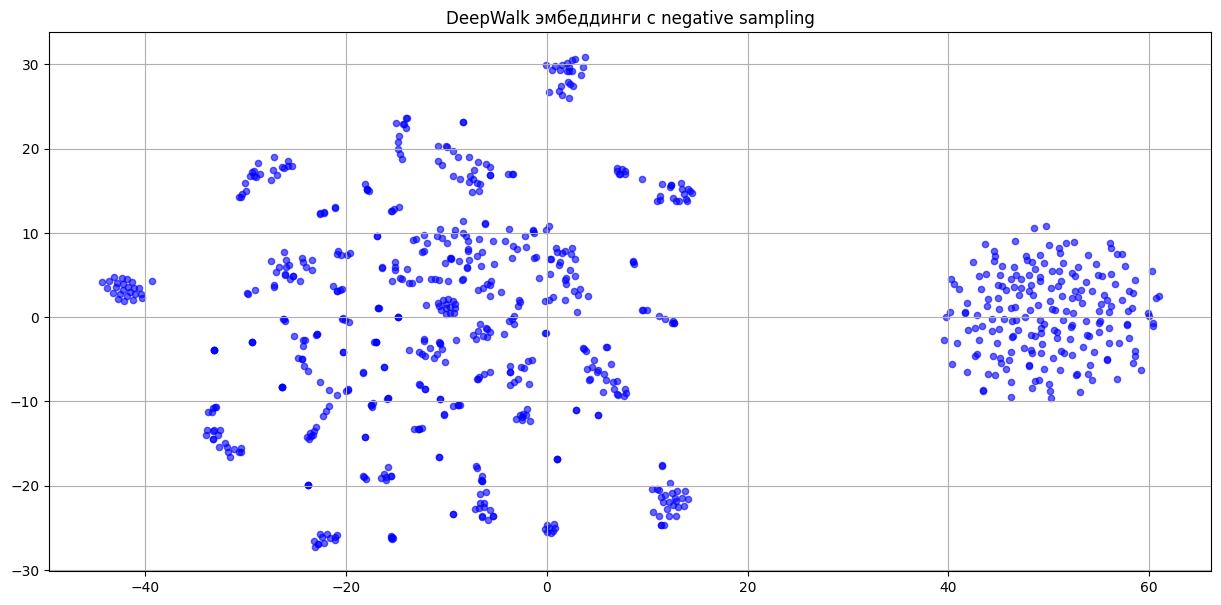

In [225]:
# Визуализируем с помощью t-SNE - при снижении размерности он просто умеет сохранять расстояния между объектами, которые были близки и в пространстве большой размерности
plt.figure(figsize=(15, 7))
embeddings = deep_walk_embeddings.weight.detach().numpy()
embeddings_2d = TSNE(n_components=2).fit_transform(embeddings)
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6, s=20, color='b')
plt.title("DeepWalk эмбеддинги с negative sampling")
plt.grid(True)
plt.show()

#### Т е что мы можем заметить - что на картинке образуются кластеры, т е похожие эмбеддинги вершин в них и объединились

In [150]:
# Теперь - множества схожих вершин
from sklearn.metrics.pairwise import cosine_similarity

top_cnt = 10

# У нас нумерация отличается от фактических номеров вершин, поэтому преобразуем
all_nodes = sorted([int(node) for node in G_sub.nodes()])

# Создаем mapping: индекс в embeddings -> реальный идентификатор вершины
idx_to_id = {i: node_id for i, node_id in enumerate(all_nodes)}

# Вычисляем попарные косинусные схожести только для вершин графа
node_embeddings = np.array([embeddings[node_id] for node_id in all_nodes])
similarities = cosine_similarity(node_embeddings)

similar_dict = {}
for i, real_node_id in enumerate(all_nodes):
    # Исключаем саму вершину и берем Топ-к
    similar_indices = np.argsort(similarities[i])[::-1][1:top_cnt+1]
    # Конвертируем индексы обратно в реальные идентификаторы вершин
    similar_real_ids = [idx_to_id[idx] for idx in similar_indices]
    similar_dict[real_node_id] = similar_real_ids



# Выводим результаты для нескольких вершин - выведем первые 10
print("Множества схожих вершин:")
for node in list(G_sub.nodes())[:10]:
    print(f"Вершина {node}: {similar_dict[node]}")


Множества схожих вершин:
Вершина 1: [483, 107, 490, 161, 51, 217, 248, 211, 471, 393]
Вершина 107: [483, 1, 217, 51, 161, 248, 211, 490, 143, 40]
Вершина 483: [161, 107, 1, 51, 217, 471, 248, 490, 211, 40]
Вершина 490: [1, 483, 107, 161, 217, 143, 51, 393, 248, 211]
Вершина 3: [448, 76, 552, 235, 726, 246, 776, 272, 129, 540]
Вершина 260: [124, 346, 345, 421, 152, 795, 415, 240, 243, 540]
Вершина 448: [3, 76, 246, 576, 540, 115, 129, 272, 776, 251]
Вершина 552: [76, 776, 115, 358, 246, 3, 41, 235, 446, 192]
Вершина 5: [728, 71, 785, 587, 748, 584, 724, 382, 526, 225]
Вершина 71: [5, 748, 728, 382, 8, 587, 785, 73, 584, 321]


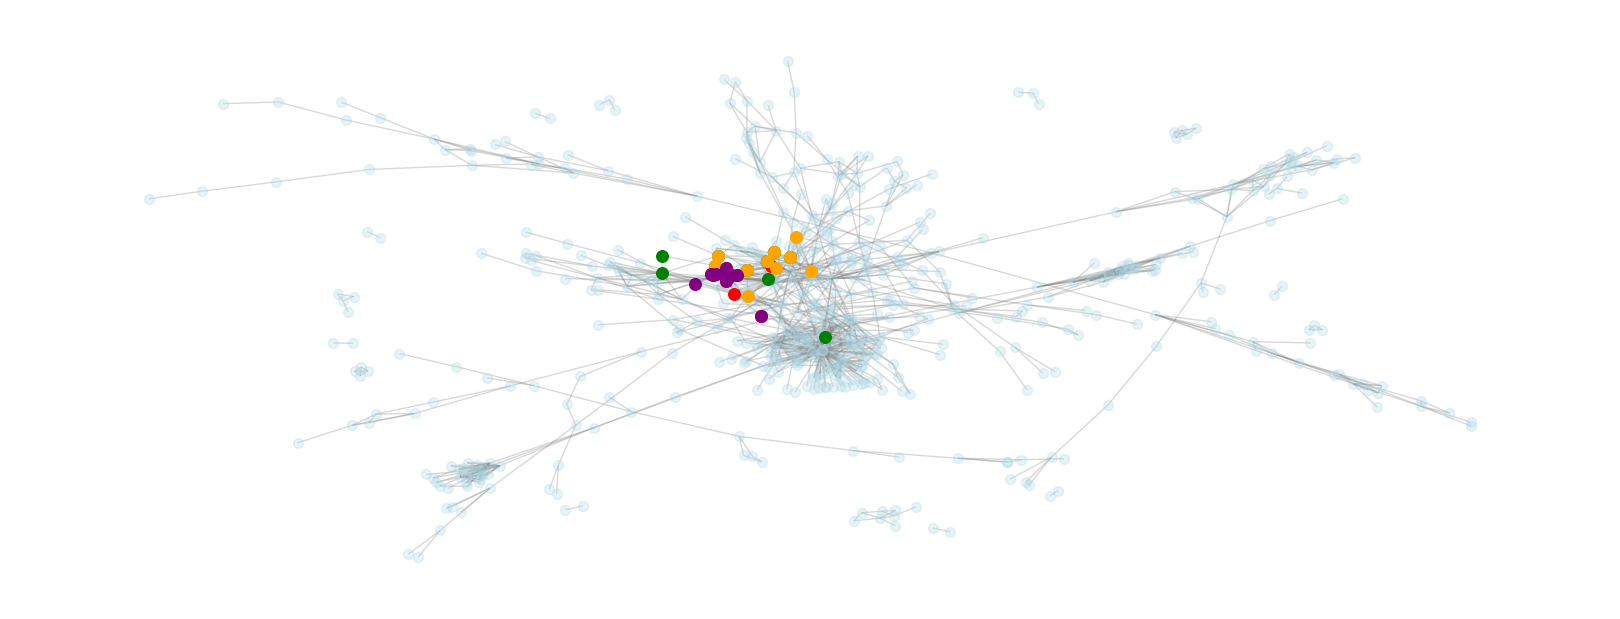

In [154]:
# Ну и попытаемся визуализировать некоторые из похожих вершин, хотя что-то увидеть на такой картинке будет трудно

plt.figure(figsize=(16, 6))

pos = nx.spring_layout(G_sub, seed=42)
nx.draw(G_sub,pos,
            node_color='lightblue',
            node_size=50,
            edge_color='gray',
            alpha=0.3,
            with_labels=False)

nx.draw_networkx_nodes(graph,pos,
                          nodelist=[483, 107, 490, 161, 51, 217, 248, 211, 471, 393],
                          node_color='red',
                          node_size=70)

nx.draw_networkx_nodes(graph,pos,
                          nodelist=[5, 748, 728, 382, 8, 587, 785, 73, 584, 321],
                          node_color='green',
                          node_size=70)

nx.draw_networkx_nodes(graph,pos,
                          nodelist=[728, 71, 785, 587, 748, 584, 724, 382, 526, 225],
                          node_color='orange',
                          node_size=70)

nx.draw_networkx_nodes(graph,pos,
                          nodelist=[1, 483, 107, 161, 217, 143, 51, 393, 248, 211],
                          node_color='purple',
                          node_size=70)

### Node2Vec

#### Если задачу декомпозировать, то нужно будет реализовать блуждания с параметрами p и q; и потом обучить классификатор

In [219]:
# Реализуем случайные блуждания для node2vec


def deep_walk_node2vec(G, num_walks=10, walk_length=5, p=1, q=1):
    walks = []

    nodes = G.nodes()
    neighbors = {node: list(G.neighbors(node)) for node in nodes}

    for node in tqdm(nodes):
        for i in range(num_walks):
            actual_node = node
            deep_walk_array = [actual_node]
            for j in range(walk_length):
                neighbors_array = list(G.neighbors(actual_node))
                if len(neighbors_array) == 0:
                    break
                elif len(deep_walk_array) == 1:
                    deep_walk_array.append(random.choice(neighbors_array))
                else:
                    prev = deep_walk_array[-2]
                    weights = []
                    for n in neighbors_array:
                        if n == prev: # Т е как раз сравниваем с предыдущей вершиной в случае p
                            weights.append(1 / p)
                        elif prev in neighbors.get(n,[]):
                            weights.append(1)
                        else:
                            weights.append(1 / q)

                    weights = np.array(weights)
                    deep_walk_array.append(np.random.choice(neighbors_array, p=weights / weights.sum()))
            walks.append(deep_walk_array)
    return walks

In [231]:
# Теперь - то же обучение, но уже с новыми блужданиями

def train_node2vec(G_sub, epoch_cnt=50, negative_samples=5, p=1.0, q=1.0):
    """Обучение эмбеддингов через Node2Vec"""

    # Генерация Node2Vec блужданий
    walks = deep_walk_node2vec(G_sub, num_walks=13, walk_length=5, p = p, q = q)
    print(f"Сгенерировано {len(walks)} Node2Vec блужданий")

    # Создаем модель для эмбеддингов
    node_list = sorted(G_sub.nodes())

    emb_sample = nn.Embedding(subgraph_size, 32)
    nn.init.normal_(emb_sample.weight, mean=0.0, std=0.1)
    optimizer = torch.optim.SGD(emb_sample.parameters(), lr=0.01)

    for epoch in range(epoch_cnt):
        total_loss = 0
        batch_count = 0

        for walk in walks:
            walk_indices = [node_list.index(node) for node in walk]
            for i, target in enumerate(walk_indices):
                if i < len(walk_indices) - 1:
                    context = walk_indices[i + 1]
                    # positive samplings
                    product = (emb_sample(torch.tensor(target)) * emb_sample(torch.tensor(context))).sum()
                    pred = torch.sigmoid(product)
                    positive_loss = -torch.log(pred)

                    # negative samplings - target и случайные вершины должны быть далеки
                    negative_loss = 0
                    for _ in range(negative_samples):
                        negative_node = random.randint(0, subgraph_size - 1)
                        # Убедимся, что это действительно негативный пример
                        while negative_node == context or negative_node == target:
                            negative_node = random.randint(0, subgraph_size - 1)

                        negative_score = (
                                emb_sample(torch.tensor(target)) * emb_sample(torch.tensor(negative_node))).sum()
                        negative_loss += -torch.log(1 - torch.sigmoid(negative_score))

                    negative_loss /= negative_samples  # усредним

                    loss = positive_loss + negative_loss
                    total_loss += loss.item()
                    batch_count += 1

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
        if epoch % 5 == 0:
            avg_loss = total_loss / batch_count
            print(f"Эпоха {epoch}, Loss: {avg_loss:.4f}")
    return emb_sample

In [232]:
# Обучаем node2vec эмбеддинги
node2vec_embeddings = train_node2vec(G_sub, p=1, q=2, epoch_cnt=60)

100%|██████████| 599/599 [00:00<00:00, 2095.06it/s]


Сгенерировано 7787 Node2Vec блужданий
Эпоха 0, Loss: 1.2669
Эпоха 5, Loss: 0.8440
Эпоха 10, Loss: 0.7909
Эпоха 15, Loss: 0.7746
Эпоха 20, Loss: 0.7613
Эпоха 25, Loss: 0.7555
Эпоха 30, Loss: 0.7467
Эпоха 35, Loss: 0.7423
Эпоха 40, Loss: 0.7364
Эпоха 45, Loss: 0.7309
Эпоха 50, Loss: 0.7254
Эпоха 55, Loss: 0.7181


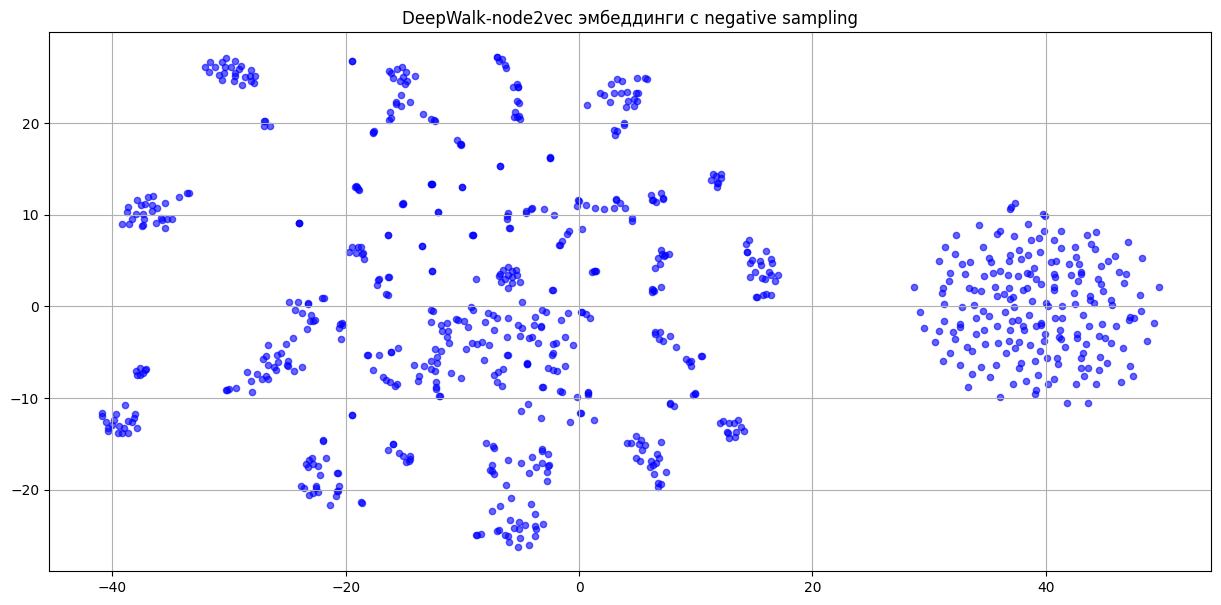

In [284]:
# Визуализируем с помощью t-SNE
plt.figure(figsize=(15, 7))
embeddings = node2vec_embeddings.weight.detach().numpy()
embeddings_2d = TSNE(n_components=2).fit_transform(embeddings)
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6, s=20, color='b')
plt.title("DeepWalk-node2vec эмбеддинги с negative sampling")
plt.grid(True)
plt.show()


# Ну т е вот можно менять эти параметры p и q и в том числе ими регулировать процесс обучения

#### Но изначально то была задача про классификацию ребер - обучим классификатор и сравним 2 подхода к созданию эмбеддингов

In [280]:
from sklearn.model_selection import train_test_split
# За классификатор возьмем обычный градиентный бустинг

from sklearn.ensemble import GradientBoostingClassifier

# Ребра, которые уже есть
positive_edges = list(G_sub.edges())
nodes = list(G_sub.nodes())

# Сюда сложим ребра которых нет
negative_edges = []

while len(negative_edges) < len(positive_edges):
    u, v = random.sample(nodes, 2)
    if not G_sub.has_edge(u, v): # Т е если ребра реально нет - то подходит и складываем в массив
        negative_edges.append((u, v))

# Создаем mapping: node_id -> embedding_index
node_to_idx = {node: i for i, node in enumerate(sorted(nodes))}

# Эмбеддинги есть, но создадим признаки
def create_features(embeddings, edges):
        features = []
        for u, v in edges:
            u_idx = node_to_idx[u]
            v_idx = node_to_idx[v]

            feature = np.concatenate([
                embeddings[u_idx],
                embeddings[v_idx],
                embeddings[u_idx] * embeddings[v_idx]
            ])
            features.append(feature)
        return np.array(features)



gbc_deep_walk = GradientBoostingClassifier(n_estimators=500, random_state=100)
gbc_node2vec = GradientBoostingClassifier(n_estimators=500, random_state=100)

deep_walk_embeddings_result = deep_walk_embeddings.weight.detach().numpy()
node2vec_embeddings_result = node2vec_embeddings.weight.detach().numpy()

X_deep_walk = create_features(deep_walk_embeddings_result, positive_edges + negative_edges)
X_node2vec = create_features(node2vec_embeddings_result, positive_edges + negative_edges)
y = np.array([1]*len(positive_edges) + [0]*len(negative_edges))


X_deep_walk_train, X_deep_walk_test, y_train, y_test = train_test_split(X_deep_walk, y, test_size=0.2, random_state=47, stratify=y)
X_node2vec_train, X_node2vec_test, _, _ = train_test_split(X_node2vec, y, test_size=0.2, random_state=47, stratify=y)

gbc_deep_walk.fit(X_deep_walk_train, y_train)
gbc_node2vec.fit(X_node2vec_train, y_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,500
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [281]:
print(classification_report(y_test, gbc_deep_walk.predict(X_deep_walk_test)))

              precision    recall  f1-score   support

           0       0.63      0.71      0.67       252
           1       0.67      0.58      0.62       253

    accuracy                           0.65       505
   macro avg       0.65      0.65      0.64       505
weighted avg       0.65      0.65      0.64       505



In [282]:
print(classification_report(y_test, gbc_node2vec.predict(X_node2vec_test)))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       252
           1       0.95      0.99      0.97       253

    accuracy                           0.97       505
   macro avg       0.97      0.97      0.97       505
weighted avg       0.97      0.97      0.97       505



Во втором случае с node2vec результат получился лучше, хоть и изображения эмбеддингов получились примерно одинаковые + сам алгоритм более гибкий с точки зрения настройки и подбора параметров смещенного случайного блуждания p и q